In [1]:
# !/usr/bin/env python
# coding: utf-8

# ---- Library import ----

import pickle
from time import gmtime, strftime

import albumentations
import math
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ---- My utils ----
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

usage: ipykernel_launcher.py [-h] [--verbose] [--epochs EPOCHS]
                             [--batch_size BATCH_SIZE]
                             [--model_name {efficientnet}]
                             [--optimizer {adam,sgd,rmsprop}]
                             [--depth_coefficient DEPTH_COEFFICIENT]
                             [--width_coefficient WIDTH_COEFFICIENT]
                             [--resolution_coefficient RESOLUTION_COEFFICIENT]
                             [--compound_coefficient COMPOUND_COEFFICIENT]
                             [--learning_rate LEARNING_RATE] [--lr_scheduler]
                             [--data_augmentation] [--img_size IMG_SIZE]
                             [--crop_size CROP_SIZE] [--output_dir OUTPUT_DIR]
                             [--path_extension PATH_EXTENSION]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1002/jupyter/kernel-ad2bdbc4-6d1a-4833-84a2-0ecbf0fe3bd7.json


Working with Jupyter notebook! (Default Arguments)


### Data

In [2]:
# Primero necesitamos reescalar (si usamos los coeficientes de Efficientnet) la resolucion de las imagenes a usar
args.crop_size = math.ceil(args.crop_size * args.resolution_coefficient)
args.img_size = math.ceil(args.img_size * args.resolution_coefficient)

In [3]:
train_aug = albumentations.Compose([
    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
    albumentations.Resize(args.img_size, args.img_size),
    albumentations.RandomCrop(p=1, height=args.crop_size, width=args.crop_size)
])

val_aug = albumentations.Compose([
    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
    albumentations.Resize(args.img_size, args.img_size),
    albumentations.CenterCrop(p=1, height=args.crop_size, width=args.crop_size)
])

In [4]:
if args.data_augmentation:
    print("Data Augmentation to be implemented...")

In [5]:
train_dataset = ISIC2019_Dataset(data_partition="train", albumentation=train_aug)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

In [6]:
val_dataset = ISIC2019_Dataset(data_partition="validation", albumentation=val_aug)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=False)
print("Data loaded!\n")

Data loaded!



### Model

In [9]:
num_classes = len(np.unique(ISIC_TRAIN_DF_TRUTH.target))
print("{} Classes detected!".format(num_classes))
model = model_selector(args.model_name, num_classes, args.depth_coefficient, args.width_coefficient)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

8 Classes detected!


### Training

In [10]:
progress_train_loss, progress_val_loss, progress_train_acc, progress_val_acc = [], [], [], []
best_loss, best_acc = 10e10, -1

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(args.optimizer, model, lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 135, 170], gamma=0.2)

In [12]:
for argument in args.__dict__:
    print("{}: {}".format(argument, args.__dict__[argument]))

output_dir: results/new_logs_efficientnet_adam
width_coefficient: 1.0
resolution_coefficient: 1.0
data_augmentation: False
compound_coefficient: 1.0
path_extension: 
epochs: 200
crop_size: 224
img_size: 256
verbose: False
learning_rate: 0.001
optimizer: adam
batch_size: 32
depth_coefficient: 1.0
lr_scheduler: False
model_name: efficientnet


In [13]:
lrs, losses = torchy.utils.findLR(model, optimizer, criterion, train_loader)

Testint LR: 1e-08
Testint LR: 1.0313186160300991e-08
Testint LR: 1.063618087770239e-08
Testint LR: 1.0969291342637834e-08
Testint LR: 1.1312834366320198e-08
Testint LR: 1.166713668205109e-08
Testint LR: 1.2032535255966933e-08
Testint LR: 1.2409377607517191e-08
Testint LR: 1.2798022139979532e-08
Testint LR: 1.3198838481326258e-08
Testint LR: 1.3612207835766212e-08
Testint LR: 1.4038523346296481e-08
Testint LR: 1.4478190468608723e-08
Testint LR: 1.493162735670572e-08
Testint LR: 1.539926526059491e-08
Testint LR: 1.5881548936437127e-08
Testint LR: 1.637893706954063e-08
Testint LR: 1.6891902710602732e-08
Testint LR: 1.742093372561389e-08
Testint LR: 1.7966533259852197e-08
Testint LR: 1.8529220216409514e-08
Testint LR: 1.9109529749704394e-08
Testint LR: 1.9708013774451142e-08
Testint LR: 2.032524149056908e-08
Testint LR: 2.0961799924531252e-08
Testint LR: 2.1618294487667407e-08
Testint LR: 2.2295349551952272e-08
Testint LR: 2.2993609043826707e-08
Testint LR: 2.371373705661653e-08
Testint LR

Testint LR: 1.588154893643698e-05
Testint LR: 1.6378937069540478e-05
Testint LR: 1.6891902710602572e-05
Testint LR: 1.7420933725613723e-05
Testint LR: 1.7966533259852024e-05
Testint LR: 1.8529220216409335e-05
Testint LR: 1.910952974970421e-05
Testint LR: 1.9708013774450952e-05
Testint LR: 2.0325241490568884e-05
Testint LR: 2.096179992453105e-05
Testint LR: 2.16182944876672e-05
Testint LR: 2.229534955195206e-05
Testint LR: 2.299360904382649e-05
Testint LR: 2.3713737056616303e-05
Testint LR: 2.4456418482131202e-05
Testint LR: 2.5222359662044488e-05
Testint LR: 2.601228905967312e-05
Testint LR: 2.682695795279697e-05
Testint LR: 2.766714114817623e-05
Testint LR: 2.8533637718446517e-05
Testint LR: 2.9427271762092496e-05
Testint LR: 3.0348893187222848e-05
Testint LR: 3.129937851989197e-05
Testint LR: 3.2279631737737196e-05
Testint LR: 3.3290585129724385e-05
Testint LR: 3.433320018281955e-05
Testint LR: 3.5408468496429806e-05
Testint LR: 3.651741272548335e-05
Testint LR: 3.766108755304542e-05

Testint LR: 0.028533637718446192
Testint LR: 0.02942727176209216
Testint LR: 0.030348893187222503
Testint LR: 0.03129937851989162
Testint LR: 0.03227963173773683
Testint LR: 0.033290585129724014
Testint LR: 0.03433320018281917
Testint LR: 0.03540846849642941
Testint LR: 0.036517412725482944
Testint LR: 0.037661087553045
Testint LR: 0.038840580693394765
Testint LR: 0.040057013926517275
Testint LR: 0.041311544164994204
Testint LR: 0.04260536455430814
Testint LR: 0.04393970560760691
Testint LR: 0.04531583637600715
Testint LR: 0.04673506565555011
Testint LR: 0.04819874323195776
Testint LR: 0.04970826116437278
Testint LR: 0.05126505510930366
Testint LR: 0.052870605686033814
Testint LR: 0.054526439884793484
Testint LR: 0.056234132519033614
Testint LR: 0.05799530772318294
Testint LR: 0.059811640497312746
Testint LR: 0.06168485830017841
Testint LR: 0.06361674269215277
Testint LR: 0.06560913102961391
Testint LR: 0.06766391821239885
Testint LR: 0.069783058485985
Testint LR: 0.07196856730011351
T

In [18]:
len(losses)

550

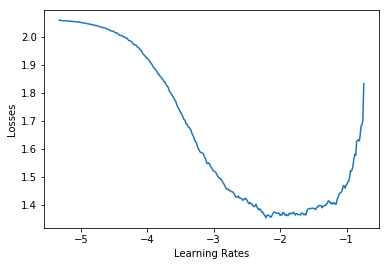

In [30]:
init, fin = 200, 543
plt.xlabel('Learning Rates')
plt.ylabel('Losses')
plt.plot(lrs[init:fin], losses[init:fin])
plt.savefig("data/lr_find_rmsprop_custom.png")
plt.show()